# Diagnostics for MCMC methods

This notebook illustrates the use of a few diagnostics for MCMC. The example consists in learning the parameters of a regression model via Bayesian inference.

In [1]:
from UQpy.sampling import MetropolisHastings
from UQpy.distributions import Normal, JointIndependent
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.List[typing.Callable] deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.Callable deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecate

### Example setup

First generate data then define the target log pdf = log likelihood $p(data \vert x)$.

In [2]:
param_true = [1., 2.]
domain = np.linspace(0, 10, 50)
data_clean = param_true[0] * domain + param_true[1] * domain ** 2
rstate = np.random.RandomState(123)
data_noisy = data_clean + rstate.randn(*data_clean.shape)

In [3]:
from scipy.stats import norm
def log_target(x, data, x_domain):
    log_target_value = np.zeros(x.shape[0])
    for i, xx in enumerate(x):
        h_xx = xx[0] * x_domain + xx[1] * x_domain ** 2
        log_target_value[i] = np.sum([norm.logpdf(hxi - datai) for hxi, datai in zip(h_xx, data)])
    return log_target_value

In [4]:
proposal = JointIndependent([Normal(scale=0.1), Normal(scale=0.05)])

sampler = MetropolisHastings(nsamples=500, dimension=2, log_pdf_target=log_target, 
                             burn_length=10, jump=10, n_chains=1,
                             args_target=(data_noisy, domain), proposal=proposal)

print(sampler.samples.shape)
samples = sampler.samples

(500, 2)


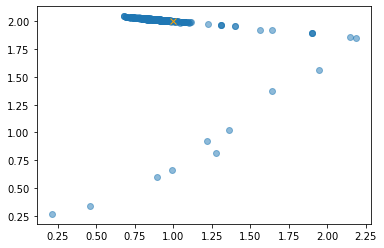

In [5]:
plt.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.5)
plt.plot(1., 2., marker='x', color='orange')
plt.show()

### Look at acceptance rate of the chain(s)

In [6]:
print(sampler.acceptance_rate)

[0.06766467065868263]


This acceptance rate is quite low, showing that the proposal should probably be refined !

### Graphics

/var/folders/t5/4jtc8k1902j5q91znr0l4z5r0000gn/T/ipykernel_83338/2360843338.py:5: RuntimeWarning: divide by zero encountered in true_divide
  ax[j, 1].plot(np.arange(samples.shape[0]), np.cumsum(samples[:, j])/np.arange(samples.shape[0]))
/var/folders/t5/4jtc8k1902j5q91znr0l4z5r0000gn/T/ipykernel_83338/2360843338.py:5: RuntimeWarning: divide by zero encountered in true_divide
  ax[j, 1].plot(np.arange(samples.shape[0]), np.cumsum(samples[:, j])/np.arange(samples.shape[0]))


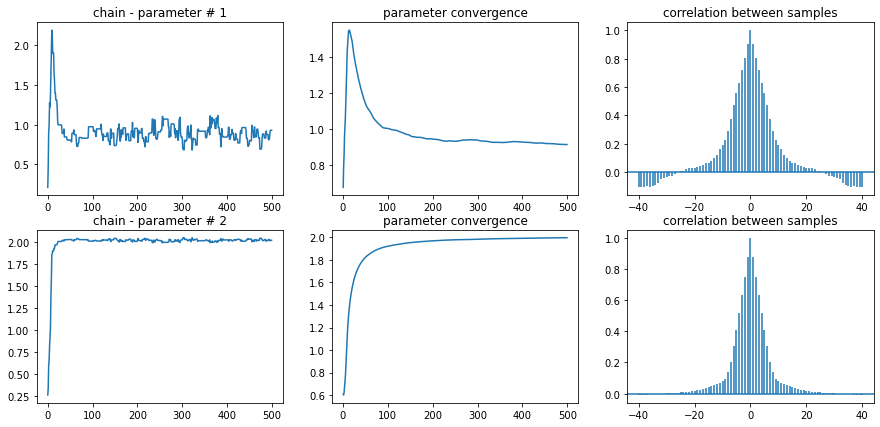

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7))
for j in range(samples.shape[1]):
    ax[j, 0].plot(np.arange(samples.shape[0]), samples[:, j])
    ax[j, 0].set_title('chain - parameter # {}'.format(j+1))
    ax[j, 1].plot(np.arange(samples.shape[0]), np.cumsum(samples[:, j])/np.arange(samples.shape[0]))
    ax[j, 1].set_title('parameter convergence')
    ax[j, 2].acorr(samples[:, j] - np.mean(samples[:, j]), maxlags=40, normed=True)
    ax[j, 2].set_title('correlation between samples')
plt.show()

### Compute effective sample size ESS

In MCMC, the $ESS$ has been used to derive termination rules, based on the quality of the estimation. In brief, the simulation stops when the computational uncertainty on a chosen quantity (for instance, the expected value of RV $x$) is small compared to its posterior uncertainty [1]. Mathematically, this allows computation of the $ESS$ and a minimum value $ESS_{min}$ (qualitatively, an acceptable approximation is reached if $ESS > ESS_{min}$). These quantities can be computed by looking at each marginal density (is $x$ is a multivariate random variable), or by looking at the joint. The reader is referred to [1, 2] for more details.

[1] *A practical sequential stopping rule for high-dimensional MCMC and its application to spatial-temporal Bayesian models*, Gong and Flegal, 2014. <br>
[2] *Multivariate Output Analysis for Markov Chain Monte Carlo*, Vats and Flegal, 2015

In [8]:
def compute_marginal_ESS(samples, eps_ESS=0.05, alpha_ESS=0.05):
    # Computation of ESS and min ESS, look at each marginal distribution separately
    nsamples, dim = samples.shape
    
    bn = np.ceil(nsamples**(1/2))    # nb of samples per bin
    an = int(np.ceil(nsamples/bn))    # nb of bins
    idx = np.array_split(np.arange(nsamples), an)

    means_subdivisions = np.empty((an, samples.shape[1]))
    for i, idx_i in enumerate(idx):
        x_sub = samples[idx_i, :]
        means_subdivisions[i, :] = np.mean(x_sub, axis=0)
    Omega = np.cov(samples.T)
    Sigma = np.cov(means_subdivisions.T)

    marginal_ESS = np.empty((dim, ))
    min_marginal_ESS = np.empty((dim,))
    for j in range(dim):
        marginal_ESS[j] = nsamples * Omega[j,j] / Sigma[j,j]
        min_marginal_ESS[j] = 4 * norm.ppf(alpha_ESS/2)**2 / eps_ESS**2
        
    return marginal_ESS, min_marginal_ESS

def compute_joint_ESS(samples, eps_ESS=0.05, alpha_ESS=0.05):
    # Computation of ESS and min ESS, look at the joint distribution separately
    nsamples, dim = samples.shape
    
    bn = np.ceil(nsamples**(1/2))    # nb of samples per bin
    an = int(np.ceil(nsamples/bn))    # nb of bins
    idx = np.array_split(np.arange(nsamples), an)

    means_subdivisions = np.empty((an, samples.shape[1]))
    for i, idx_i in enumerate(idx):
        x_sub = samples[idx_i, :]
        means_subdivisions[i, :] = np.mean(x_sub, axis=0)
    Omega = np.cov(samples.T)
    Sigma = np.cov(means_subdivisions.T)
    
    from scipy.stats import chi2
    from scipy.special import gamma
    joint_ESS = nsamples*np.linalg.det(Omega)**(1/dim)/np.linalg.det(Sigma)**(1/dim)
    chi2_value = chi2.ppf(1 - alpha_ESS, df=dim)
    min_joint_ESS = 2 ** (2 / dim) * np.pi / (dim * gamma(dim / 2)) ** (
                2 / dim) * chi2_value / eps_ESS ** 2
    
    return joint_ESS, min_joint_ESS

In [9]:
marginal_ESS, min_marginal_ESS = compute_marginal_ESS(samples, eps_ESS=0.05, alpha_ESS=0.05)

print('Univariate Effective Sample Size in each dimension:')
for j in range(2):
    print('Dimension {}: ESS = {}, minimum ESS recommended = {}'.
          format(j+1, marginal_ESS[j], min_marginal_ESS[j]))

Univariate Effective Sample Size in each dimension:
Dimension 1: ESS = 1007.6729870678739, minimum ESS recommended = 6146.334113110603
Dimension 2: ESS = 1164.9336565152505, minimum ESS recommended = 6146.334113110603


In [10]:
joint_ESS, min_joint_ESS = compute_joint_ESS(samples, eps_ESS=0.05, alpha_ESS=0.05)

print('\nMultivariate Effective Sample Size:')
print('Multivariate ESS = {}, minimum ESS recommended = {}'.format(joint_ESS, min_joint_ESS))


Multivariate Effective Sample Size:
Multivariate ESS = 2947.1997665521917, minimum ESS recommended = 7529.096402175249


Results abobe show that the chains should probably be run for a longer amount of time in order to obtain reliable results in terms of the expected value of the parameters to be learnt.